In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy import optimize, stats
import matplotlib.pyplot as plt
import math
import pprint as pp

# funk cover of lizzo? yes plz https://www.youtube.com/watch?v=gNbPoQBm0zM

In [4]:
# Parameters
k = 2
times = np.linspace(0,10,100)

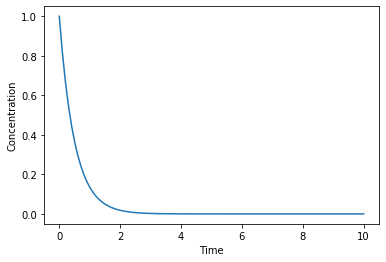

In [5]:
def onecomp(y, t, k):
    dydt = -k * y
    return dydt

def simulate(func, parameters, y0, times):
    return odeint(func, y0, times, (parameters,))

ys = simulate(onecomp, k, 1, times)


# Plot the results
values = ys.reshape((100,))
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)
plt.show()

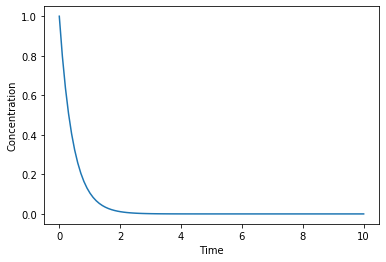

In [6]:
# or you could do it with forward euler
def ForwardEuler(func, k, y0, times):
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)

    return y_solution

# Plot the results
values = ys.reshape((100,))
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, ForwardEuler(onecomp, k, 1, times))
plt.show()

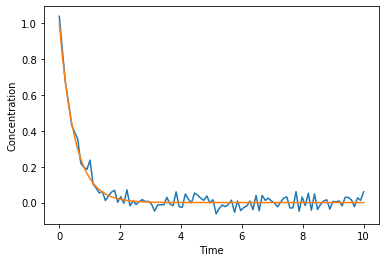

In [7]:
# Make noisy data
noisy_data = values + np.random.normal(0, 0.03, values.shape)
plt.figure()
plt.plot(times, noisy_data)
plt.plot(times, values)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [8]:
# So what do we want to minimise?
def sumofsquares(y_model, y_data):
    sq_error = []
    for t in range(len(y_model)):
        sq_error.append((y_data[t] - y_model[t])**2)
    
    return sum(sq_error) / len(y_model)

In [9]:
# Optimise it with scipy
def scalar_to_minimise(parameters):
    y_model = simulate(onecomp, parameters, 1, times)
    y_data = noisy_data
    return sumofsquares(y_model, y_data)

start_params = 11
result = optimize.minimize_scalar(scalar_to_minimise)
print(result)

     fun: array([0.00093656])
    nfev: 15
     nit: 10
 success: True
       x: array([1.91052089])


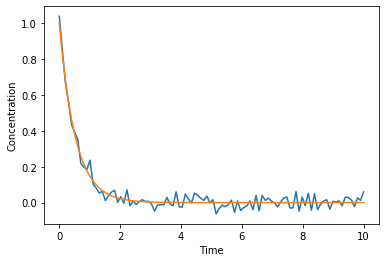

In [10]:
# What does that look like?
recon_model = simulate(onecomp, result.x, 1, times)
plt.figure()
plt.plot(times, noisy_data)
plt.plot(times, recon_model)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

Likelihood:

$Pr(y|k,sigma) = \prod_{i=1}^{N} 1/(2\pi\sigma^2) \text{exp}(-(y(t_i)-exp(-k t_i))^2/(2\sigma^2))$

Priors:

k ~ U(0, 10)  
sigma ~ U(0, 10)  
Pr(k) = 1/10, if k in [0, 10] or 0 otherwise  
Pr(sigma) = 1/10 ...  

$Pr(\theta|x) = \frac{Pr(X|\theta) Pr(\theta)}{Pr(X)}$

Pr(y|k,sigma) * Pr(k) * Pr(sigma)

In [13]:
# gets this: (sigma_1, sigma_2,...,sigma_n), (k_1,k_2,...,k_n)

**Metropolis sampling**

Assuming that our only two inputs ($\theta$) are k (gradient scaling) and $\sigma$ (SD of noise)...

We want to find $Pr(\theta|X)$ (the posterior), which is a function giving the probability distribution for the model input parameters: that is, for each possible combination of input parameters, a likelihood that that is the combination producing this output. Input $\theta$ (vector, output probability density (scalar).

$Pr(\theta|X) = \frac{Pr(X|\theta) Pr(\theta)}{Pr(X)}$  
RHS has three parts: 
- $Pr(\theta)$: prior. Function that gives a probability density (scalar) from $\theta$ (vector). Here, gives 0.1 for all values of k & $\sigma$ between 0 and 10.
- $Pr(X|\theta)$: likelihood. It's just a crazy function that takes $\theta$ and gives a scalar. Accept and move on.
- $Pr(X)$: A number that normalises (makes the posterior integrate to 1).

**Steps**
1. Start with an arbitrary $\theta$ (a k and a $\sigma$). Calculate prior x likelihood.
2. Move to a different $\theta$ (+/- an amount from a normal distribution with SD given by the 'covariate matrix'). Calculate prior x likelihood.
3. If new prior x likelihood is higher than old, keep it and add the new $\theta$ to a list. If not, keep it if rand(0->1) > (old/new). If neither of these work, move back to the old one and add that instead.
4. Repeat steps 2-3 for N steps. 
5. Count your list of $\theta$s into bins and draw a histogram. This approximates your posterior.

In [ ]:
# This model stores all the model-related variables, so there's less weird passing of vars between functions

class OdeModel():
    
    def __init__(self, y_model, prior, likelihood):
        self.thetas = [[{'k':1, 's':1}],
                       [{'k':2, 's':2}],
                       [{'k':3, 's':3}]]
        self.covariates = {'k':1, 's':1}
        self.y = y_model
        self.prior = prior
        self.likelihood = likelihood
        
    
model = OdeModel(values, uniform_prior, likelihood)
# thetas = all thetas for all starting values
# thetas_onelot = a list of thetas from a single set of starting values = thetas[n]
# theta = one set of theta values, in a dict = thetas[n][m] = thetas_onelot[m]

In [48]:
def uniform_prior(theta):

    prior = []
    for key, param in theta.items():
        #print('key '+key+' value '+str(param))
        if type(param) == list:
            print('DEBUG: THIS IS PARAM')
            print(param)
        if param > 0 and param < 10:
            prior.append(0.1)
        else:
            prior.append(0)
            
    return min(prior)


def likelihood(theta, y_model, y_data):
    k = theta['k']
    sigma = theta['s']
    exponential = -sumofsquares(y_model, y_data) / (2*sigma**2)
    
    return 1/(2*math.pi*sigma**2) * math.exp(exponential)

In [47]:
def propose_new_theta(model, y_data, theta):

    numerator = model.prior(theta) * model.likelihood(theta, model.y, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = {}
    for key, value in theta.items():
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = model.prior(proposed_theta) * model.likelihood(proposed_theta, model.y, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta
    if proposed_numerator == 0:
        pass
    elif proposed_numerator > numerator:
        theta = proposed_theta
        numerator = proposed_numerator
    elif np.random.rand() > numerator/proposed_numerator:
        theta = proposed_theta
        numerator = proposed_numerator
    return theta

# Test that this works
start_theta = [1, 1]

result = propose_new_theta(model, noisy_data, {'k':1, 's':1})
print(result)

key k value 1
key s value 1
key k value 1.5481297047206335
key s value 0.9449547064498324
{'k': 1.5481297047206335, 's': 0.9449547064498324}


In [62]:
def metropolis_singlethread(model, y_data, threadnum, max_iters):
    iters = 0
    
    while iters < max_iters:
        theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
        model.thetas[threadnum].append(theta)
        iters = iters + 1

# test this works
model = OdeModel(values, uniform_prior, likelihood)
metropolis_singlethread(model, noisy_data, 0, 10)
print(model.thetas[0])

[{'k': 1, 's': 1}, {'k': 1, 's': 1}, {'k': 1.145571629547454, 's': 0.8743176918192845}, {'k': 1.2100888181993357, 's': 0.8092386006930385}, {'k': 1.2100888181993357, 's': 0.8092386006930385}, {'k': 1.2753885240779328, 's': 0.7531018728363134}, {'k': 1.2753885240779328, 's': 0.7531018728363134}, {'k': 1.2753885240779328, 's': 0.7531018728363134}, {'k': 1.3932089483481551, 's': 0.7271671964774344}, {'k': 1.441231488696853, 's': 0.5340537542857096}, {'k': 1.441231488696853, 's': 0.5340537542857096}]


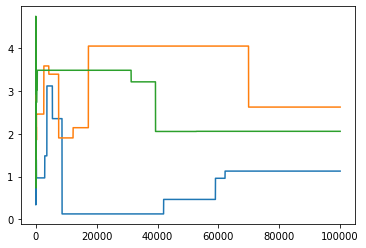

In [66]:
def metropolishastings(model, y_data, blocksize, number_of_blocks):
    n = 0
    while n < number_of_blocks:
        for threadnum, thetas_onelot in enumerate(model.thetas):
            metropolis_singlethread(model, y_data, threadnum, blocksize)
        n = n+1
        
# Does it work?
model = OdeModel(values, uniform_prior, likelihood)
metropolishastings(model, noisy_data, 1000, 1000)
plt.figure()
for n in range(len(model.thetas)):
    k = [theta['k'] for theta in model.thetas[n]]
    plt.plot(range(len(k)), k)
plt.show()

In [65]:
#TODO: Make all model parameters into params of an object, for simpler passing around.
#TODO: Gelman Rubin convergence calculation.




1